In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install scikit-learn-intelex


# ***Importing Necessary Dependancies :***

---



In [ ]:
# Built-in Modules
import os
import re
import zipfile
import warnings

# Data Science and Machine Learning Libraries
import dpnp as np
import modin.pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearnex import patch_sklearn
patch_sklearn()


# Text Processing Libraries
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Import Intel Extension for Scikit-learn and apply patch
from sklearnex import patch_sklearn
patch_sklearn()  # This optimizes scikit-learn for Intel hardware

# Now, import the usual scikit-learn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC

# NLTK Data Downloads
nltk.download('punkt')
nltk.download('stopwords')

import intel_tensorflow as tf

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


# Configuration
# ============================
# Ignore warnings
warnings.filterwarnings("ignore")

# Set maximum column width for pandas DataFrame display
pd.set_option('display.max_colwidth', None)

# Set seaborn theme for visualizations
sns.set_theme()

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# NLTK Data Downloads
nltk.download('punkt')
nltk.download('stopwords')

# Install Required Libraries
!pip install scikit-learn

ModuleNotFoundError: No module named 'dpnp'

# ***Loading Dataset :***

---



In [ ]:
data = pd.read_csv('/kaggle/input/pheme-dataset-for-rumour-detection/dataset.csv')

In [ ]:
data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})

,is_rumor
count,62443.000000
mean,0.221386
std,0.415183
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
data.head()

,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago,0.0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBCDanielS: Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago”",0.0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is being considered terrorism right now or lone wolf?,0.0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention that before knowing the facts #islamphobiaatitsbest,0.0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0.0,freethought41,charliehebdo


In [ ]:
data['num_words'] = data['text'].apply(lambda x: len(x.split()))
avg_words = round(data['num_words'].mean())
max_words = round(data['num_words'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

print("--------------------")
data['is_rumor'].value_counts()

Average length: 14
Max length: 34
--------------------


is_rumor
0.0    48619
1.0    13824
Name: count, dtype: int64

# **Data shape:**

---



In [ ]:
print(f'The number of columns: = {data.shape[1]}\nThe number of rows: = {data.shape[0]}')

# Check dublicates:
print("dublicated Data: ", data.duplicated().sum())

The number of columns: = 5
The number of rows: = 62445
dublicated Data:  800


In [ ]:
# Drop dublicates
df = data.drop_duplicates()

# Check dublicates:
df.duplicated().sum()

0

In [ ]:
# Drop blanks columns:

# Identify the rows with blank values
blanks = df.isnull().any(axis=1)

# Drop the rows with blank values
df.drop(df[blanks].index, inplace=True)

# Final Shape:
print(f'The number of columns: = {df.shape[1]}\nThe number of rows: = {df.shape[0]}')

The number of columns: = 5
The number of rows: = 48871


In [ ]:
df['is_rumor'].value_counts()

is_rumor
0.0    42590
1.0     6281
Name: count, dtype: int64

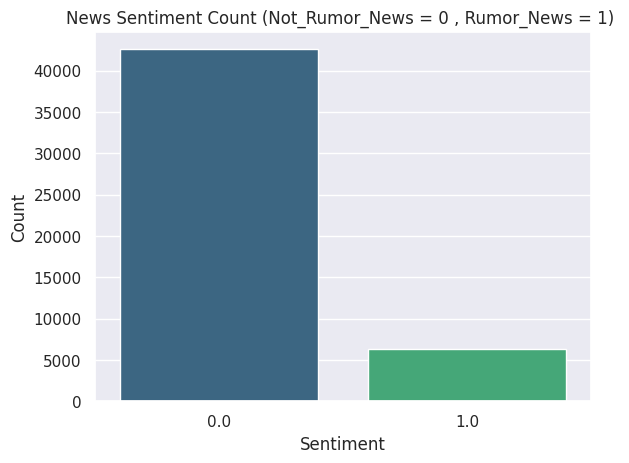

In [ ]:
# Assume (Rumor_News = 1 ,  Not_Rumor_News = 0)
sns.countplot(data=df, x='is_rumor', palette='viridis')
plt.title('News Sentiment Count (Not_Rumor_News = 0 , Rumor_News = 1) ')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Percentage of Our is_rumor in dataset')

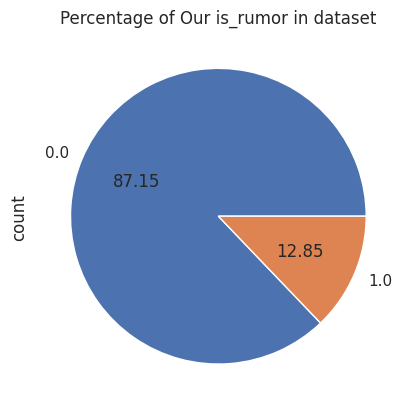

In [ ]:
df['is_rumor'].value_counts().plot.pie(autopct='%.2f')
plt.title('Percentage of Our is_rumor in dataset')

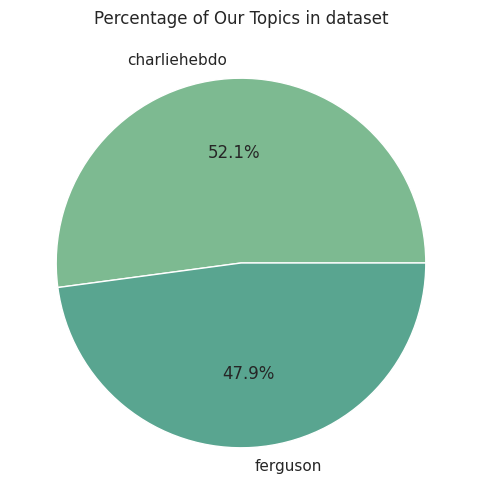

In [ ]:
sns.set_palette("crest")
sns.set_style("whitegrid")

plt.figure(figsize=(6, 6))
df['topic'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Percentage of Our Topics in dataset')
plt.ylabel(None)
plt.show()

# **Needed only columns is:**


---


*   Test.
*   Target.

In [ ]:
# df = df[['text', 'target']]
# df.head()

# **Text Preprocessing**

---
*   Convert text to lowercase and remove unnecessary characters
*   Tokenization
*   Removing special characters
*   Removing stop words and punctuation
*   Stemming







In [ ]:

# Assuming df is your DataFrame
df_class_0 = df[df['is_rumor'] == 0.0].sample(n=6281, random_state=42)
df_class_1 = df[df['is_rumor'] == 1.0]

# Combine the two samples into a new DataFrame
df_balanced = pd.concat([df_class_0, df_class_1])

# Shuffle the DataFrame to mix the rows
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df

,text,is_rumor,user.handle,topic,num_words
0,"@decyberdiva So you're arguing that the legal definition of robbery vs. theft is contingent upon the victim's ""feelings"" LOL",1.0,slow17motion,ferguson,19
1,@forumeditor @LeftSentThis I think his point still stands though. it doesn't matter if all religions were subject to his satire.,0.0,jrdnvns,charliehebdo,20
2,@sunnyright @lkatrell @7im Well aware rank and file NRA members are not as extreme as the leadership.,0.0,ShroudSciuridae,ferguson,17
3,@cnn he died because we're tired of this Muslims rats violence all over the world,0.0,Iuckystarr,charliehebdo,15
4,@baratunde well said. Insecure people are easily manipulated. Easily controlled by the media. Sleeper terrorists. .,0.0,shampoovta,charliehebdo,16
...,...,...,...,...,...
12557,@rolandsmartin @slsdem http://t.co/4U8fd1zHH3,1.0,DocTexian,ferguson,3
12558,@ta2t2o @menzymenz @WesleyLowery @AntonioFrench I guess we shouldn't be allowed to peacefully protest.,0.0,SCALEZd,ferguson,13
12559,@Chilingaroff @BBCWorld Thought the Ukraine asked for help because of Russia.,0.0,BubbleBeeBath,charliehebdo,11
12560,@BiddyEarly @selfstyledsiren and that is what I mean. I think who and what I was asking was clear. But asking the honest question offends,0.0,draziraphale,charliehebdo,24


In [ ]:
df['is_rumor'].value_counts()

is_rumor
1.0    6281
0.0    6281
Name: count, dtype: int64

In [ ]:
# Convert text to lowercase and remove unnecessary characters
df.loc[:, 'text'] = df['text'].str.lower().str.replace('[^\w\s]', '', regex=True)
df['text']

0                       decyberdiva so youre arguing that the legal definition of robbery vs theft is contingent upon the victims feelings lol
1                  forumeditor leftsentthis i think his point still stands though it doesnt matter if all religions were subject to his satire
2                                            sunnyright lkatrell 7im well aware rank and file nra members are not as extreme as the leadership
3                                                              cnn he died because were tired of this muslims rats violence all over the world
4                                baratunde well said insecure people are easily manipulated easily controlled by the media sleeper terrorists 
                                                                         ...                                                                  
12557                                                                                                   rolandsmartin slsdem httptco4u8fd1zhh3

In [ ]:
# Remove Punctuation
def remove_pun(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['text'] = df['text'].apply(remove_pun)

df.head()

,text,is_rumor,user.handle,topic,num_words
0,decyberdiva so youre arguing that the legal definition of robbery vs theft is contingent upon the victims feelings lol,1.0,slow17motion,ferguson,19
1,forumeditor leftsentthis i think his point still stands though it doesnt matter if all religions were subject to his satire,0.0,jrdnvns,charliehebdo,20
2,sunnyright lkatrell 7im well aware rank and file nra members are not as extreme as the leadership,0.0,ShroudSciuridae,ferguson,17
3,cnn he died because were tired of this muslims rats violence all over the world,0.0,Iuckystarr,charliehebdo,15
4,baratunde well said insecure people are easily manipulated easily controlled by the media sleeper terrorists,0.0,shampoovta,charliehebdo,16


In [ ]:
pip install nltk --index-url https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# # remove stopwords
# def remove_stopwords(text):
#     # Download the stopwords corpus if it hasn't been downloaded already
#     nltk.download('stopwords', quiet=True)

#     # Get the list of stopwords
#     stop_words = set(stopwords.words('english'))

#     # Split the text into words
#     words = text.split()

#     # Remove the stopwords
#     filtered_words = [word for word in words if word.lower() not in stop_words]

#     # Join the filtered words back into a single string
#     filtered_text = ' '.join(filtered_words)

#     return filtered_text

# df['text'] = df['text'].apply(remove_stopwords)

# df.head()

In [ ]:
# Tokenization
def data_processing(text):
    # Remove mentions and hashtags
    text = re.sub(r'\@w+|\#', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    text_tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if w.lower() not in stop_words]

    return " ".join(filtered_text)

df['text'] = df['text'].apply(data_processing)

df.head()

,text,is_rumor,user.handle,topic,num_words
0,decyberdiva youre arguing legal definition robbery vs theft contingent upon victims feelings lol,1.0,slow17motion,ferguson,19
1,forumeditor leftsentthis think point still stands though doesnt matter religions subject satire,0.0,jrdnvns,charliehebdo,20
2,sunnyright lkatrell 7im well aware rank file nra members extreme leadership,0.0,ShroudSciuridae,ferguson,17
3,cnn died tired muslims rats violence world,0.0,Iuckystarr,charliehebdo,15
4,baratunde well said insecure people easily manipulated easily controlled media sleeper terrorists,0.0,shampoovta,charliehebdo,16


In [ ]:
# Stemmer
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df['text'] = df['text'].apply(stemming)

df.head()

,text,is_rumor,user.handle,topic,num_words
0,decyberdiva youre arguing legal definition robbery vs theft contingent upon victims feelings lol,1.0,slow17motion,ferguson,19
1,forumeditor leftsentthis think point still stands though doesnt matter religions subject satire,0.0,jrdnvns,charliehebdo,20
2,sunnyright lkatrell 7im well aware rank file nra members extreme leadership,0.0,ShroudSciuridae,ferguson,17
3,cnn died tired muslims rats violence world,0.0,Iuckystarr,charliehebdo,15
4,baratunde well said insecure people easily manipulated easily controlled media sleeper terrorists,0.0,shampoovta,charliehebdo,16


In [ ]:
# # Ensure 'is_rumor' is integer type
# data.loc['is_rumor'] = data['is_rumor'].astype(int)
# data['is_rumor']

# Ensure 'is_rumor' is integer type
# Fill missing values with a suitable integer (e.g., -1 to represent unknown)
df['is_rumor'] = df['is_rumor'].fillna(-1).astype(int)

# Display the 'is_rumor' column to verify the changes
df['is_rumor']

0        1
1        0
2        0
3        0
4        0
        ..
12557    1
12558    0
12559    0
12560    0
12561    1
Name: is_rumor, Length: 12562, dtype: int64

In [ ]:
# Apply on 'text' column contains the text data in train_df
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

# Display the DataFrame with the new 'num_words' column
print(df[['text', 'num_words']])

print('------------------------------------------------------------------------------')

avg_words = round(df['num_words'].mean())
max_words = round(df['num_words'].max())

print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

                                                                                                    text  \
0       decyberdiva youre arguing legal definition robbery vs theft contingent upon victims feelings lol   
1        forumeditor leftsentthis think point still stands though doesnt matter religions subject satire   
2                            sunnyright lkatrell 7im well aware rank file nra members extreme leadership   
3                                                             cnn died tired muslims rats violence world   
4      baratunde well said insecure people easily manipulated easily controlled media sleeper terrorists   
...                                                                                                  ...   
12557                                                             rolandsmartin slsdem httptco4u8fd1zhh3   
12558              ta2t2o menzymenz wesleylowery antoniofrench guess shouldnt allowed peacefully protest   
12559                       

<Axes: xlabel='num_words', ylabel='Count'>

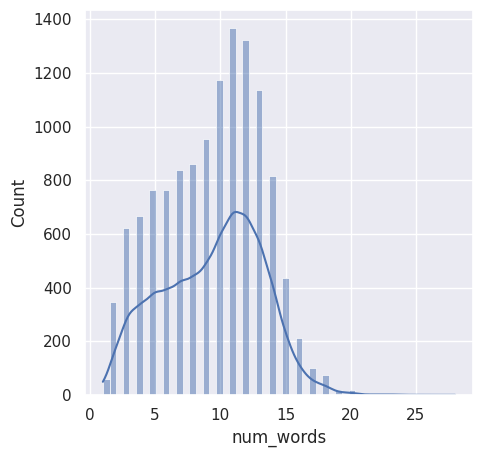

In [ ]:
sns.set(rc = {'figure.figsize':(5,5)})
sns.histplot(df['num_words'], kde=True)

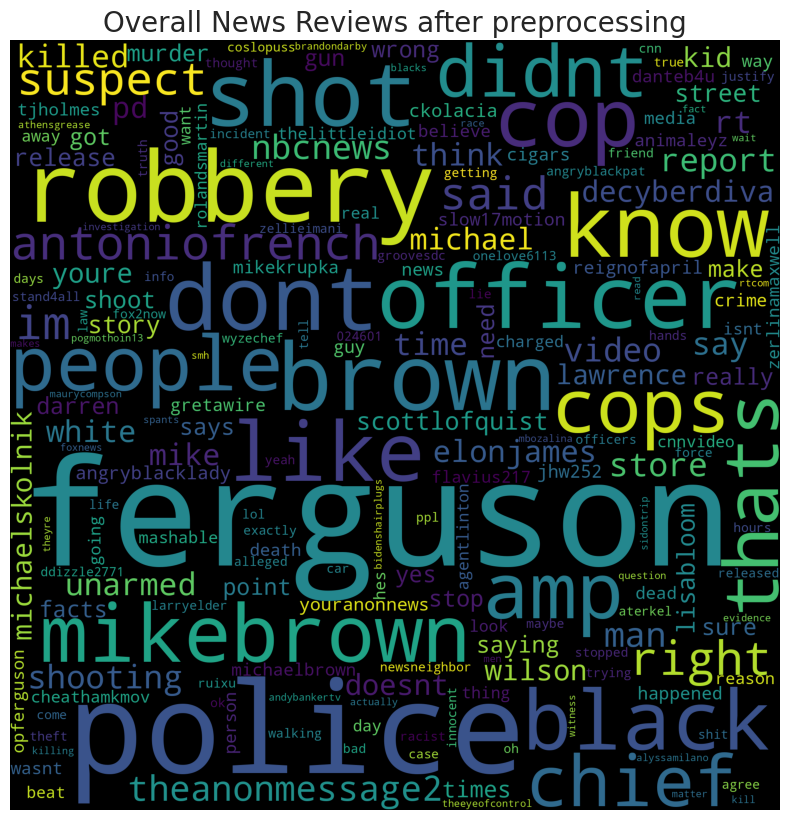

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df[df['is_rumor'] == 1]['text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Overall News Reviews after preprocessing", fontsize = 20)
plt.show()

# **Model Building**

---


# Initialize DeBERTa-v3 Model and Tokenizer for Sequence Classification

In [ ]:
# Initialize the tokenizer and model
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier', 'cls_dropout', 'pooler']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenize the datasets

In [ ]:
# Splitting the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Function to tokenize the data
def tokenize_data(data, tokenizer, max_length):
    return tokenizer(
        list(data['text']),  # Assuming the text column is named 'text'
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Tokenize the train and test datasets
max_length = 64
train_encodings = tokenize_data(train_df, tokenizer, max_length)
test_encodings = tokenize_data(test_df, tokenizer, max_length)

# Create TensorFlow datasets

In [ ]:
# Create TensorFlow datasets
def create_tf_dataset(encodings, labels):
    labels = tf.convert_to_tensor(labels.values)
    dataset = tf.data.Dataset.from_tensor_slices((
        {key: encodings[key] for key in encodings if key in ['input_ids', 'attention_mask']},
        labels
    ))
    return dataset

batch_size = 16
train_dataset = create_tf_dataset(train_encodings, train_df['is_rumor']).batch(batch_size)
test_dataset = create_tf_dataset(test_encodings, test_df['is_rumor']).batch(batch_size)

# Train the model

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    batch_size=batch_size,
    epochs=15
)

# Save the model
model_save_path = "/content/saved_model"
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = "/content/saved_tokenizer"
tokenizer.save_pretrained(tokenizer_save_path)

Epoch 1/15
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1725222001.458342      89 service.cc:145] XLA service 0x795014a0bcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725222001.458399      89 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725222001.458403      89 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725222001.622576      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


629/629 [==============================] - 364s 407ms/step - loss: 0.5405 - accuracy: 0.7168 - val_loss: 0.3864 - val_accuracy: 0.8237
Epoch 2/15
629/629 [==============================] - 235s 373ms/step - loss: 0.3249 - accuracy: 0.8618 - val_loss: 0.3497 - val_accuracy: 0.8695
Epoch 3/15
629/629 [==============================] - 234s 372ms/step - loss: 0.2125 - accuracy: 0.9147 - val_loss: 0.2345 - val_accuracy: 0.9113
Epoch 4/15
629/629 [==============================] - 234s 373ms/step - loss: 0.1405 - accuracy: 0.9459 - val_loss: 0.2270 - val_accuracy: 0.9176
Epoch 5/15
629/629 [==============================] - 235s 373ms/step - loss: 0.1131 - accuracy: 0.9586 - val_loss: 0.3338 - val_accuracy: 0.9005
Epoch 6/15
629/629 [==============================] - 235s 373ms/step - loss: 0.0809 - accuracy: 0.9730 - val_loss: 0.4304 - val_accuracy: 0.8814
Epoch 7/15
629/629 [==============================] - 234s 373ms/step - loss: 0.0546 - accuracy: 0.9810 - val_loss: 0.3688 - val_accura

('/content/saved_tokenizer/tokenizer_config.json',
 '/content/saved_tokenizer/special_tokens_map.json',
 '/content/saved_tokenizer/spm.model',
 '/content/saved_tokenizer/added_tokens.json',
 '/content/saved_tokenizer/tokenizer.json')

# Training history

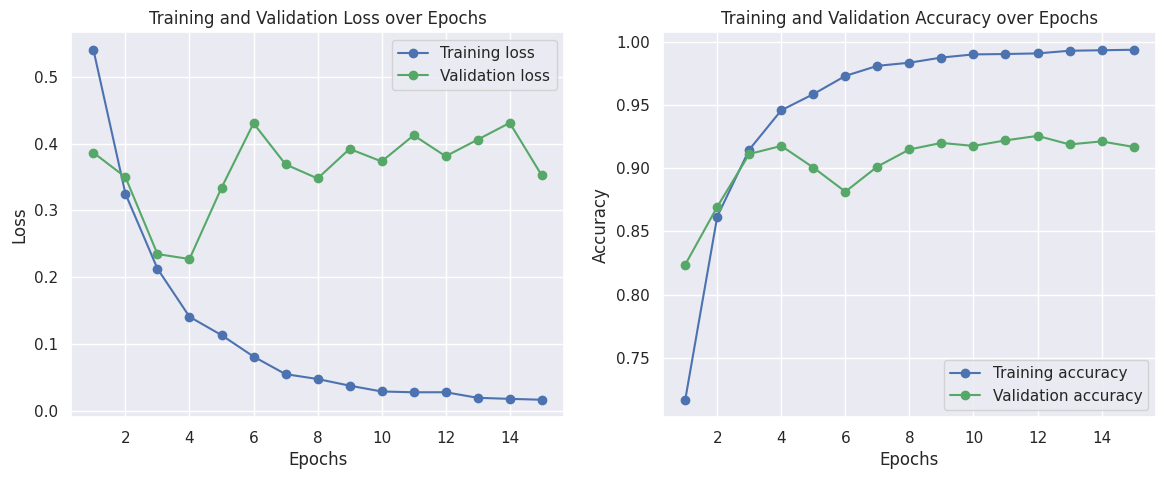

In [ ]:
# Extract training metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))  # Create an epoch list

# Plot training loss and validation loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'g-o', label='Validation loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Extract training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-o', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g-o', label='Validation accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Load and Evaluate Pretrained Sequence Classification Model

In [ ]:
# Load the model
loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_save_path)

# Load the tokenizer
loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

# Compile the model
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

test_loss, test_accuracy = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

All the layers of TFDebertaV2ForSequenceClassification were initialized from the model checkpoint at /content/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.


158/158 [==============================] - 47s 95ms/step - loss: 0.3523 - accuracy: 0.9168
Test Loss: 0.3523
Test Accuracy: 0.9168


# Evaluate Model Predictions and Display Metrics

Accuracy: 0.9168
F1 Score: 0.9168
Precision: 0.9179
Recall: 0.9168

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      1262
           1       0.94      0.89      0.91      1251

    accuracy                           0.92      2513
   macro avg       0.92      0.92      0.92      2513
weighted avg       0.92      0.92      0.92      2513



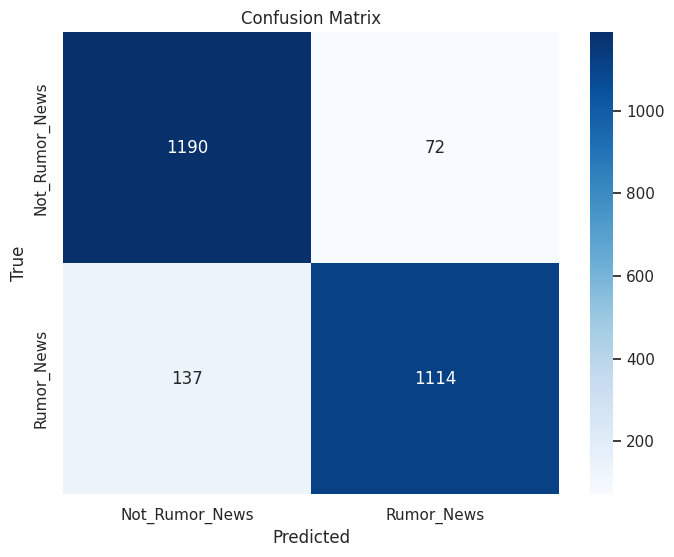

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to make predictions on the test dataset
def get_predictions(model, dataset):
    predictions = []
    true_labels = []
    for batch in dataset:
        inputs = {key: val for key, val in batch[0].items()}
        labels = batch[1].numpy()
        logits = model(inputs, training=False).logits  # Ensure you access the logits
        batch_predictions = np.argmax(logits.numpy(), axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(labels)
    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
predictions, true_labels = get_predictions(loaded_model, test_dataset)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Show classification report
report = classification_report(true_labels, predictions)
print("\nClassification Report:\n", report)

# Mapping dictionary
# Not_Rumor_News = 0 , Rumor_News = 1
label_mapping = {'Not_Rumor_News': 0, 'Rumor_News': 1}
labels = list(label_mapping.keys())

# Display confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Zip Trained Model and Tokenizer for Storage

In [ ]:
import zipfile
import os


# Zip file name
zip_file_name = "/content/trained_model_and_tokenizer.zip"

# Zip the directories
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model files to the zip
    for root, _, files in os.walk(model_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(model_save_path, '..')))

    # Add tokenizer files to the zip
    for root, _, files in os.walk(tokenizer_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(tokenizer_save_path, '..')))

print(f"Model and tokenizer zipped successfully to {zip_file_name}.")


Model and tokenizer zipped successfully to /content/trained_model_and_tokenizer.zip.
